In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:87% !important; }</style>"))

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import sys
import matplotlib as mpl
from matplotlib import rc
from matplotlib.lines import Line2D
from collections import Counter
mpl.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 18})

In [4]:
### Load fastas
fa_16s = '/gpfs/commons/groups/innovation/will/nano2ome/refs/ec16s.fasta'
fa_23s = '/gpfs/commons/groups/innovation/will/nano2ome/refs/ec23s.fasta'
fa_18s = '/gpfs/commons/groups/innovation/will/nano2ome/refs/sc18s.fasta'
fa_25s = '/gpfs/commons/groups/innovation/will/nano2ome/refs/sc25s.fasta'

In [5]:
### function to process fasta
def gen_seq(fa_path):
    target_seq = ''.join([line.rstrip() for line in open(fa_path,'r')][1:]).replace('T','U') ## Change DNA fasta to RNA
    idx_ = np.arange(start=1, stop=len(target_seq)+1)  ## Generate a position index
    seq_ = pd.DataFrame({'pos': idx_, 'seq': list(target_seq)}) ## seq_ dataframe of the index and fasta RNA sequence
    return seq_

# run function on all rRNA fastas
seq16s = gen_seq(fa_16s)
seq23s = gen_seq(fa_23s)
seq18s = gen_seq(fa_18s)
seq25s = gen_seq(fa_25s)


## Generate sequence strings of the rRNAs
seq16s_list = seq16s['seq'].tolist()
seq16s_str = ''.join(seq16s_list)

seq18s_list = seq18s['seq'].tolist()
seq18s_str = ''.join(seq18s_list)

seq23s_list = seq23s['seq'].tolist()
seq23s_str = ''.join(seq23s_list)

seq25s_list = seq25s['seq'].tolist()
seq25s_str = ''.join(seq25s_list)


In [6]:
### Mean dwell from tombo
len_16si = 1538
len_18si = 1796
dwell_16si = pd.read_csv('/gpfs/commons/home/wstephenson/1623i_lsc.dwell.plus.wig', delim_whitespace=True, skiprows = 2, names=['pos', 'dwell'], nrows = len_16si,  engine='python')
dwell_23si = pd.read_csv('/gpfs/commons/home/wstephenson/1623i_lsc.dwell.plus.wig', delim_whitespace=True, skiprows = len_16si+3, names=['pos', 'dwell'],  engine='python')
dwell_18si = pd.read_csv('/gpfs/commons/home/wstephenson/1825i_lsc.dwell.plus.wig', delim_whitespace=True, skiprows = 2, names=['pos', 'dwell'], nrows = len_18si,  engine='python')
dwell_25si = pd.read_csv('/gpfs/commons/home/wstephenson/1825i_lsc.dwell.plus.wig', delim_whitespace=True, skiprows = len_18si+3, names=['pos', 'dwell'],  engine='python')

In [7]:
dwell_16si.head()

,pos,dwell
0,2,19.0952
1,3,23.3043
2,4,26.4643
3,5,16.4286
4,6,22.8662


In [28]:
##function to determine the sequences causing the highest dwell times
def top_seqs(fraction, seq_in, df_dwell_in, seq_str_in, left_start, right_end):
    n_frac = int(np.ceil(fraction * len(seq_in)))
    sort_dwell_df = df_dwell_in.sort_values(by=['dwell'], ascending=False)
    top_dwell_df = sort_dwell_df[0:n_frac]
    topseqs_ = []
    for i in top_dwell_df['pos']:
        seq_append = seq_str_in[i-left_start:i-right_end]
        topseqs_.append(seq_append)
        #print(seq_append)
        pass
    return topseqs_

frac = 0.01
left =  20  ## How many nts to look at left (upstream) of the pore constriction (5' direction)
right= -10  ## How many nts to look at right (downstream) of the pore constriction (3' direction)

x16 = top_seqs(frac, seq16s, dwell_16si, seq16s_str, left, right)
x23 = top_seqs(frac, seq23s, dwell_23si, seq23s_str, left, right)
x18 = top_seqs(frac, seq18s, dwell_18si, seq18s_str, left, right)
x25 = top_seqs(frac, seq25s, dwell_25si, seq25s_str, left, right)

seq_all = x16 + x23 + x18 + x25



In [29]:
## function to determine the fractional nucleotide counts for the highest dwell times
def calc_perc_counts(seq, dwell, n_pts, mp5, mp3):
    percentiles = np.linspace(1,99, n_pts)
    fracs       = [(100-x)*0.01 for x in percentiles]
    df_summary  = pd.DataFrame(columns = ('perc', 'frac', 'a_count', 'g_count', 'c_count', 'u_count', 'tot_count')) ## generate empty dataframe with characteristics to fill
    i = 0
    for frac in fracs:
        perc          = 100 - (frac/0.01)
        n_dw          = int(np.ceil(frac*len(seq)))
        sorted_dwells = dwell.sort_values(by=['dwell'], ascending=False)
        frac_dwells   = sorted_dwells[0:n_dw]
        
        seqs = []
        a_sum = 0
        g_sum = 0
        c_sum = 0
        u_sum = 0
        total_sum = 0
        for pos in frac_dwells['pos']:   ## determine the nucleotide fractions (count) for the dwell times in the region mp5 (motor protein position towards 5 prime) to mp3 (mp pos towards 3 prime)
            seql = seq[pos-mp5:pos-mp3]
            seqs.append(seql)
            a_sum += seql.count('A')
            g_sum += seql.count('G')
            c_sum += seql.count('C')
            u_sum += seql.count('U')
            total_sum += len(seql) 
        df_summary.loc[i] = [perc, frac, a_sum, g_sum, c_sum, u_sum, total_sum]
        i+=1
    return df_summary

In [30]:
mp5 = 12
mp3 = 9
num_pts = 20

## run function to determine percent counts for all rRNAs in the given range (3 nts comprising the motorprotein position)

stat_16s = calc_perc_counts(seq16s_str, dwell_16si, num_pts, mp5, mp3)
stat_18s = calc_perc_counts(seq18s_str, dwell_18si, num_pts, mp5, mp3)
stat_23s = calc_perc_counts(seq23s_str, dwell_23si, num_pts, mp5, mp3)
stat_25s = calc_perc_counts(seq25s_str, dwell_25si, num_pts, mp5, mp3)

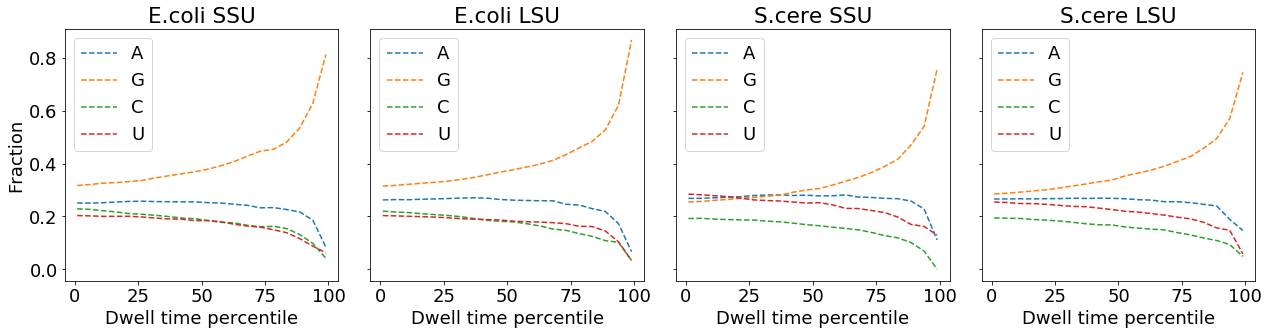

In [31]:
fig1, axs = plt.subplots(1,4, figsize=(18,5), sharey=True)
axs[0].plot(stat_16s['perc'], stat_16s['a_count']/stat_16s['tot_count'], '--', label = 'A')
axs[0].plot(stat_16s['perc'], stat_16s['g_count']/stat_16s['tot_count'], '--', label = 'G')
axs[0].plot(stat_16s['perc'], stat_16s['c_count']/stat_16s['tot_count'], '--', label = 'C')
axs[0].plot(stat_16s['perc'], stat_16s['u_count']/stat_16s['tot_count'], '--', label = 'U')

axs[1].plot(stat_23s['perc'], stat_23s['a_count']/stat_23s['tot_count'], '--', label = 'A')
axs[1].plot(stat_23s['perc'], stat_23s['g_count']/stat_23s['tot_count'], '--', label = 'G')
axs[1].plot(stat_23s['perc'], stat_23s['c_count']/stat_23s['tot_count'], '--', label = 'C')
axs[1].plot(stat_23s['perc'], stat_23s['u_count']/stat_23s['tot_count'], '--', label = 'U')

axs[2].plot(stat_18s['perc'], stat_18s['a_count']/stat_18s['tot_count'], '--', label = 'A')
axs[2].plot(stat_18s['perc'], stat_18s['g_count']/stat_18s['tot_count'], '--', label = 'G')
axs[2].plot(stat_18s['perc'], stat_18s['c_count']/stat_18s['tot_count'], '--', label = 'C')
axs[2].plot(stat_18s['perc'], stat_18s['u_count']/stat_18s['tot_count'], '--', label = 'U')

axs[3].plot(stat_25s['perc'], stat_25s['a_count']/stat_25s['tot_count'], '--', label = 'A')
axs[3].plot(stat_25s['perc'], stat_25s['g_count']/stat_25s['tot_count'], '--', label = 'G')
axs[3].plot(stat_25s['perc'], stat_25s['c_count']/stat_25s['tot_count'], '--', label = 'C')
axs[3].plot(stat_25s['perc'], stat_25s['u_count']/stat_25s['tot_count'], '--', label = 'U')

for i in range(len(axs)):
    axs[i].set_xlabel('Dwell time percentile')
    axs[i].legend(loc='upper left')
    axs[i].set_xticks([0, 25, 50, 75, 100])
axs[0].set_yticks(np.arange(0.0, 1.0, 0.2))
axs[0].set_ylabel('Fraction')
axs[0].set_title('E.coli SSU')
axs[1].set_title('E.coli LSU')
axs[2].set_title('S.cere SSU')
axs[3].set_title('S.cere LSU')

fig1.tight_layout()
#fig1.savefig('plots/dwell_percentiles.pdf')